FACET is composed of the following key components:

- **Model Inspection**

    FACET introduces a new algorithm to quantify dependencies and interactions between features in ML models. This new tool for human-explainable AI adds a new, global perspective to the observation-level explanations provided by the popular [SHAP](https://shap.readthedocs.io/en/latest/) approach. To learn more about FACET's model inspection capabilities, see the getting started example below.


- **Model Simulation**

    FACET's model simulation algorithms use ML models for *virtual experiments* to help identify scenarios that optimise predicted  outcomes. To quantify the uncertainty in simulations, FACET utilises a range of bootstrapping algorithms including stationary and stratified bootstraps. For an example of FACET’s bootstrap simulations, see the getting started example below.    
    
    
- **Enhanced Machine Learning Workflow**  

    FACET offers an efficient and transparent machine learning workflow, enhancing [scikit-learn]( https://scikit-learn.org/stable/index.html)'s tried and tested pipelining paradigm with new capabilities for model selection, inspection, and simulation. FACET also introduces [sklearndf](https://github.com/BCG-Gamma/sklearndf), an augmented version of *scikit-learn* with enhanced support for *pandas* dataframes that ensures end-to-end traceability of features.       

In [2]:
# this cell's metadata contains
# "nbsphinx": "hidden" so it is hidden by nbsphinx

import warnings

warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt

def _configure_matplotlib():
    # set global options for matplotlib

    import matplotlib

    matplotlib.rcParams["figure.figsize"] = (16.0, 8.0)
    matplotlib.rcParams["figure.dpi"] = 72


_configure_matplotlib()

del _configure_matplotlib

# Pipelining & Model Ranking

To demonstrate the model inspection capability of FACET, we first create a pipeline to fit a learner. In this simple example using the Boston housing data, we will train a Random Forest regressor using 10 repeated 5-fold CV to predict median house price. With the use of *sklearndf* we can create a *pandas* DataFrame compatible workflow. However, FACET provides additional enhancements to keep track of our feature matrix and target vector using a sample object (`Sample`) and easily compare hyperparameter configurations and even multiple learners with the `LearnerRanker`.

In [3]:
# standard imports
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import RepeatedKFold

# some helpful imports from sklearndf
from sklearndf.pipeline import RegressorPipelineDF
from sklearndf.regression import RandomForestRegressorDF

# relevant FACET imports
from facet.data import Sample
from facet.selection import LearnerRanker, LearnerGrid

# load Boston housing dataset
boston = load_boston()
boston_df = pd.DataFrame(data=boston.data, columns=boston.feature_names).assign(
    MEDIAN_HOUSE_PRICE=boston.target
)

# create FACET sample object
boston_sample = Sample(observations=boston_df, target_name="MEDIAN_HOUSE_PRICE")

# create pipeline for random forest regressor
rforest_reg = RegressorPipelineDF(regressor=RandomForestRegressorDF(random_state=42))

# define grid of models which are "competing" against each other
rnd_forest_grid = [
    LearnerGrid(
        pipeline=rforest_reg, learner_parameters={"min_samples_leaf": [8, 11, 15]}
    )
]

# create repeated k-fold CV iterator
rkf_cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

# rank your models by performance (default is mean CV score - 2*SD)
ranker = LearnerRanker(grids=rnd_forest_grid, cv=rkf_cv, n_jobs=-3).fit(sample=boston_sample)

# get summary report
ranker.summary_report()

ranking_score  r2_score                          regressor  \
                        mean       std                     type   
rank                                                              
0         0.721234  0.813158  0.045962  RandomForestRegressorDF   
1         0.706528  0.801775  0.047623  RandomForestRegressorDF   
2         0.691872  0.788968  0.048548  RandomForestRegressorDF   

                       
     min_samples_leaf  
rank                   
0                   8  
1                  11  
2                  15

We can see based on this minimal workflow that a value of 8 for minimum samples in the leaf was the best performing of the three considered values. This approach easily extends to multiple hyperparameters for the learner and multiple learners.

# Model inspection

FACET implements several model inspection methods for
[scikit-learn](<https://scikit-learn.org/stable/index.html>) estimators.
FACET enhances model inspection by providing global metrics that complement 
the local perspective of SHAP. The key global metrics for each pair of 
features in a model are:

- **Redundancy**

  The degree to which a feature in a model duplicates the information of a second feature to predict the target. For example,
  let's assume we had house size and number of bedrooms for predicting house price. These features capture similar information
  as the more bedrooms the larger the house and likely a higher price on average. The redundancy for (number of bedrooms, house
  size) will be greater than the redundancy for (house size, number of bedrooms). This is because house size "knows" more of
  what number of bedrooms does for predicting house price than vice-versa. Hence, there is greater redundancy from the
  perspective of number of bedrooms. Another way to think about it is removing house size will be more detrimental to model
  performance than removing number of bedrooms, as house size can better compensate for the absence of number of bedrooms. This
  also implies that house size would be a more important feature than number of bedrooms in the model. *This leads to an
  important point: redundancy is a naturally asymmetric property of the global information feature pairs have for predicting an
  outcome.* Redundancy is expressed as a percentage ranging from 0% (full uniqueness) to 100% (full redundancy).


- **Synergy**

  The degree to which the model combines information from one feature with another to predict the target. For example, let's
  assume we are predicting cardiovascular health using age and gender and the fitted model includes a complex interaction
  between these features. This means these two features are synergistic for predicting cardiovascular health. Further, both
  features are important to the model and removing either one would significantly impact performance. However, assume age is a
  more important feature than gender and so age contributes more to the combined prediction than gender. This asymmetric
  contribution means that the synergy for (age, gender) is greater than the synergy for (gender, age). To think about it
  another way, imagine the prediction is a coordinate you are trying to reach, basically age gets you much closer than gender
  to this point from where you start, but you need both age and gender to get there. *The important point here is that like
  redundancy, synergy is a naturally asymmetric property of global information feature pairs have when interacting to predict
  an outcome.* Synergy is expressed as a percentage ranging from 0% (full autonomy) to 100% (full synergy).

In [ ]:
# fit the model inspector
from facet.inspection import LearnerInspector
inspector = LearnerInspector()
inspector.fit(crossfit=ranker.best_model_crossfit_)

**Redundancy**

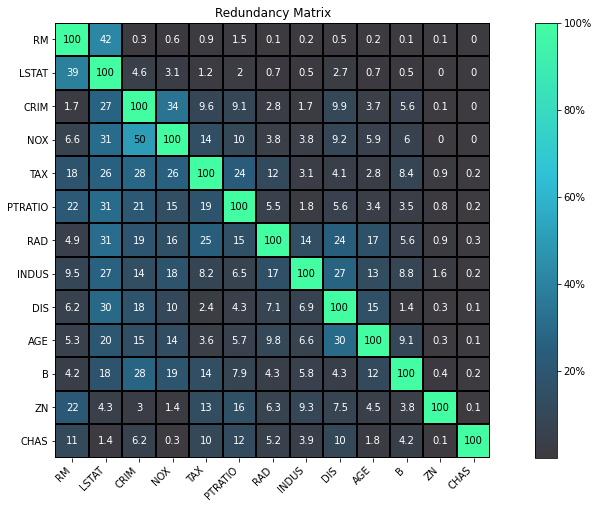

In [4]:
# visualise redundancy as a matrix
from pytools.viz.matrix import MatrixDrawer
redundancy_matrix = inspector.feature_redundancy_matrix()
MatrixDrawer(style="matplot%").draw(redundancy_matrix, title="Redundancy Matrix")

# save copy of plot to _static directory for documentation
plt.savefig(
    "facet/sphinx/source/_static/redundancy_matrix.png",
    bbox_inches="tight",
    pad_inches=0,
)

For any feature pair (A, B), the first feature (A) is the row, and the second feature (B) the column. For example, if we look at the feature pair (`LSTAT`, `RM`) from the perspective of `LSTAT` (percentage of lower status of the population), then we look-up the row for `LSTAT` and the column for `RM` (average number of rooms per dwelling) and find 39% redundancy. This means that 39% of the information in `LSTAT` is duplicated with `RM` to predict median house price.
We can also see looking across the row for `LSTAT` that apart from the 39% redundancy with `RM`, `LSTAT` has minimal redundancy (<5%) with any of the other features included in the model.

**Clustering redundancy**

As detailed above redundancy and synergy for a feature pair is from the "perspective" of one of the features in the pair, and so yields two distinct values. However, a symmetric version can also be computed that provides not only a simplified perspective but allows the use of (1 - metric) as a feature distance. With this distance hierarchical, single linkage clustering is applied to create a dendrogram visualization. This helps to identify groups of low distance, features which activate "in tandem" to predict the outcome. Such information can then be used to either reduce clusters of highly redundant features to a subset or highlight clusters of highly synergistic features that should always be considered together.

Let's look at the example for redundancy.

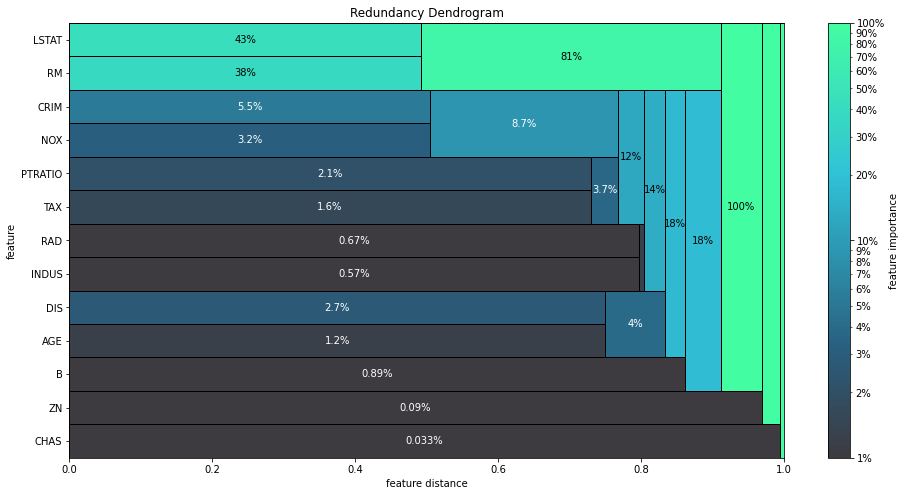

In [5]:
# visualise redundancy using a dendrogram
from pytools.viz.dendrogram import DendrogramDrawer
redundancy = inspector.feature_redundancy_linkage()
DendrogramDrawer().draw(data=redundancy, title="Redundancy Dendrogram")

# save copy of plot to _static directories for documentation
plt.savefig(
    "facet/sphinx/source/_static/redundancy_dendrogram.png",
    bbox_inches="tight",
    pad_inches=0,
)

Based on the dendrogram we can see that the feature pairs (`LSTAT`, `RM`) and (`CRIM`: per capita crime rate by town, `NOX`: nitric oxides concentration in parts per 10 million) each represent a cluster in the dendrogram and that `LSTAT` and `RM` have high importance. As a next action we could remove RM (and maybe NOX) to further simplify the model and obtain a set of independent features.

**Synergy**

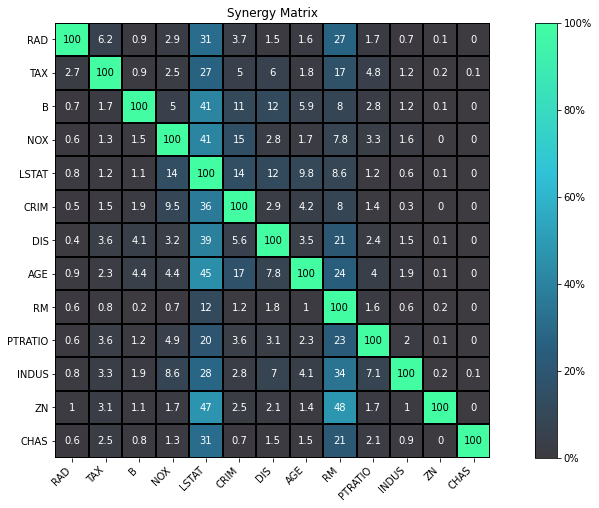

In [6]:
# visualise synergy as a matrix
synergy_matrix = inspector.feature_synergy_matrix()
MatrixDrawer(style="matplot%").draw(synergy_matrix, title="Synergy Matrix")

# save copy of plot to _static directory for documentation
plt.savefig(
    "facet/sphinx/source/_static/synergy_matrix.png", bbox_inches="tight", pad_inches=0
)

As before the matrix row represents the "perspective from" feature in the pair. Looking across the row for `LSTAT` there is relatively minimal synergy (≤14%) with other features in the model. However, looking down the column for `LSTAT` (i.e., perspective of other features in a pair with `LSTAT`) we find many features (the rows) are synergistic (12% to 47%) with `LSTAT`. We can conclude that:

- `LSTAT` is a strongly autonomous feature, displaying minimal synergy with other features for predicting median house price.
- The contribution of other features to predicting median house price is partly enabled by the strong contribution from `LSTAT`.

High synergy features must be considered carefully when investigating business impact, as they work together to predict the outcome. It would not make much sense to consider `ZN` (proportion of residential land zoned for lots over 25,000 sq.ft) without `LSTAT` given the 47% synergy of `ZN` with `LSTAT` for predicting median house price.

Note we can also see a related pattern in synergy for `RM` which we know has a moderate degree of redundancy with `LSTAT`.

# Simulation

Taking the LSTAT feature as an example, we do the following for the simulation: 

- We use FACET's `ContinuousRangePartitioner` to split the range of observed values of LSTAT into intervals of equal size. Each partition is represented by the central value of that partition. 
- For each partition, the simulator creates an artificial copy of the original sample assuming the variable to be simulated has the same value across all observations - which is the value representing the partition. Using the best `LearnerCrossfit` acquired from the ranker, the simulator now re-predicts all targets using the models trained for all folds and determines the average uplift of the target variable resulting from this.
- The FACET `SimulationDrawer` allows us to visualise the result; both in a matplotlib and a plain-text style.

Finally, because FACET can use bootstrap cross validation, we can create a crossfit from our previous `LearnerRanker` best model to perform the simulation so we can quantify the uncertainty by using bootstrap confidence intervals.

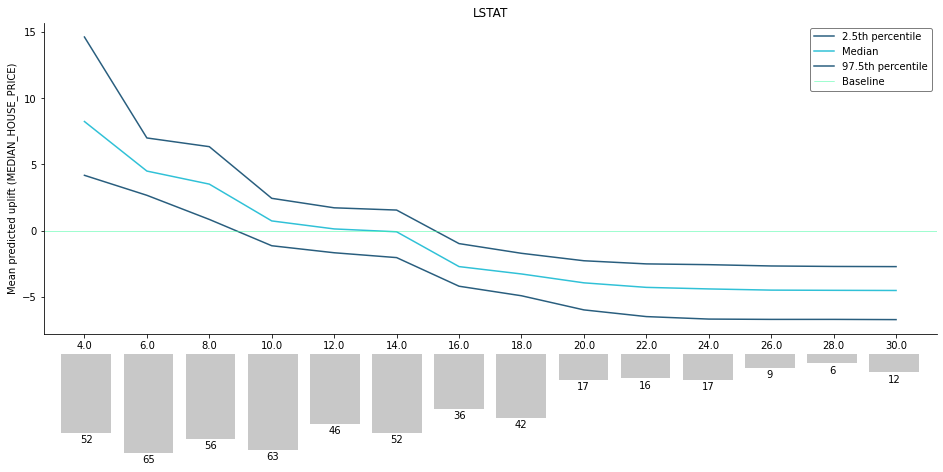

In [7]:
# FACET imports
from facet.validation import BootstrapCV
from facet.crossfit import LearnerCrossfit
from facet.simulation import UnivariateUpliftSimulator
from facet.simulation.partition import ContinuousRangePartitioner
from facet.simulation.viz import SimulationDrawer

# create bootstrap CV iterator
bscv = BootstrapCV(n_splits=1000, random_state=42)

# create a bootstrap CV crossfit for simulation using best model
boot_crossfit = LearnerCrossfit(
    pipeline=ranker.best_model_,
    cv=bscv,
    n_jobs=-3,
    verbose=False,
).fit(sample=boston_sample)

SIM_FEAT = "LSTAT"
simulator = UnivariateUpliftSimulator(crossfit=boot_crossfit, n_jobs=-3)

# split the simulation range into equal sized partitions
partitioner = ContinuousRangePartitioner()

# run the simulation
simulation = simulator.simulate_feature(feature_name=SIM_FEAT, partitioner=partitioner)

# visualise results
SimulationDrawer().draw(data=simulation, title=SIM_FEAT)

# save copy of plot to _static directory for documentation
plt.savefig(
    "facet/sphinx/source/_static/simulation_output.png",
    bbox_inches="tight",
    pad_inches=0,
)

We would conclude from the figure that lower values of `LSTAT` are associated with an increase in median house price, and that the lower `LSTAT` of 8% or less results in a significant uplift in median house price.